In [1]:
import os
os.chdir("/home/yxcai/Yuchang/SARMA")
from src.sarma.estimator import SARMAEstimator

import pandas as pd
import numpy as np
from tqdm import tqdm
from src.utils.help_empirical import *

In [2]:
labels = ['IP', 'UR', 'CPI', 'RW', 'CONS', 'FFR']
# ------------------------------------------------
df = pd.read_csv("data/FRED-MD.csv", header=0, index_col=0)

vars_ = ['INDPRO','UNRATE','CPIAUCSL','W875RX1','DPCERA3M086SBEA','FEDFUNDS']
df = df[vars_]
df = df.iloc[1:]
# ------------------------------------------------
# 2. FRED-MD transform code
# ------------------------------------------------
transform_codes = {
    'INDPRO': 5,
    'UNRATE': 2,
    'CPIAUCSL': 6,
    'W875RX1': 5,
    'DPCERA3M086SBEA': 5,
    'FEDFUNDS': 2
}

def fred_md_transform(x: pd.Series, code: int) -> pd.Series:
    if code == 1:          # level
        return x
    elif code == 2:        # first difference
        return x.diff()
    elif code == 3:        # second difference
        return x.diff().diff()
    elif code == 4:        # log level
        return np.log(x)
    elif code == 5:        # Δ log
        return np.log(x).diff()
    elif code == 6:        # Δ² log
        return np.log(x).diff().diff()
    else:
        raise ValueError(f"Unknown transform code: {code}")

# ------------------------------------------------
# 3. stationarize
# ------------------------------------------------
df_trans = pd.DataFrame(index=df.index)

for v in vars_:
    df_trans[v] = fred_md_transform(df[v], transform_codes[v])

# ------------------------------------------------
# 4. deleta NaN
# ------------------------------------------------
df_trans = df_trans.dropna(how="any")

# ------------------------------------------------
# 5. std
# ------------------------------------------------
df_std = (df_trans - df_trans.mean()) / df_trans.std(ddof=0)



In [3]:
df_std.columns = labels

In [4]:
T,N = df_std.shape

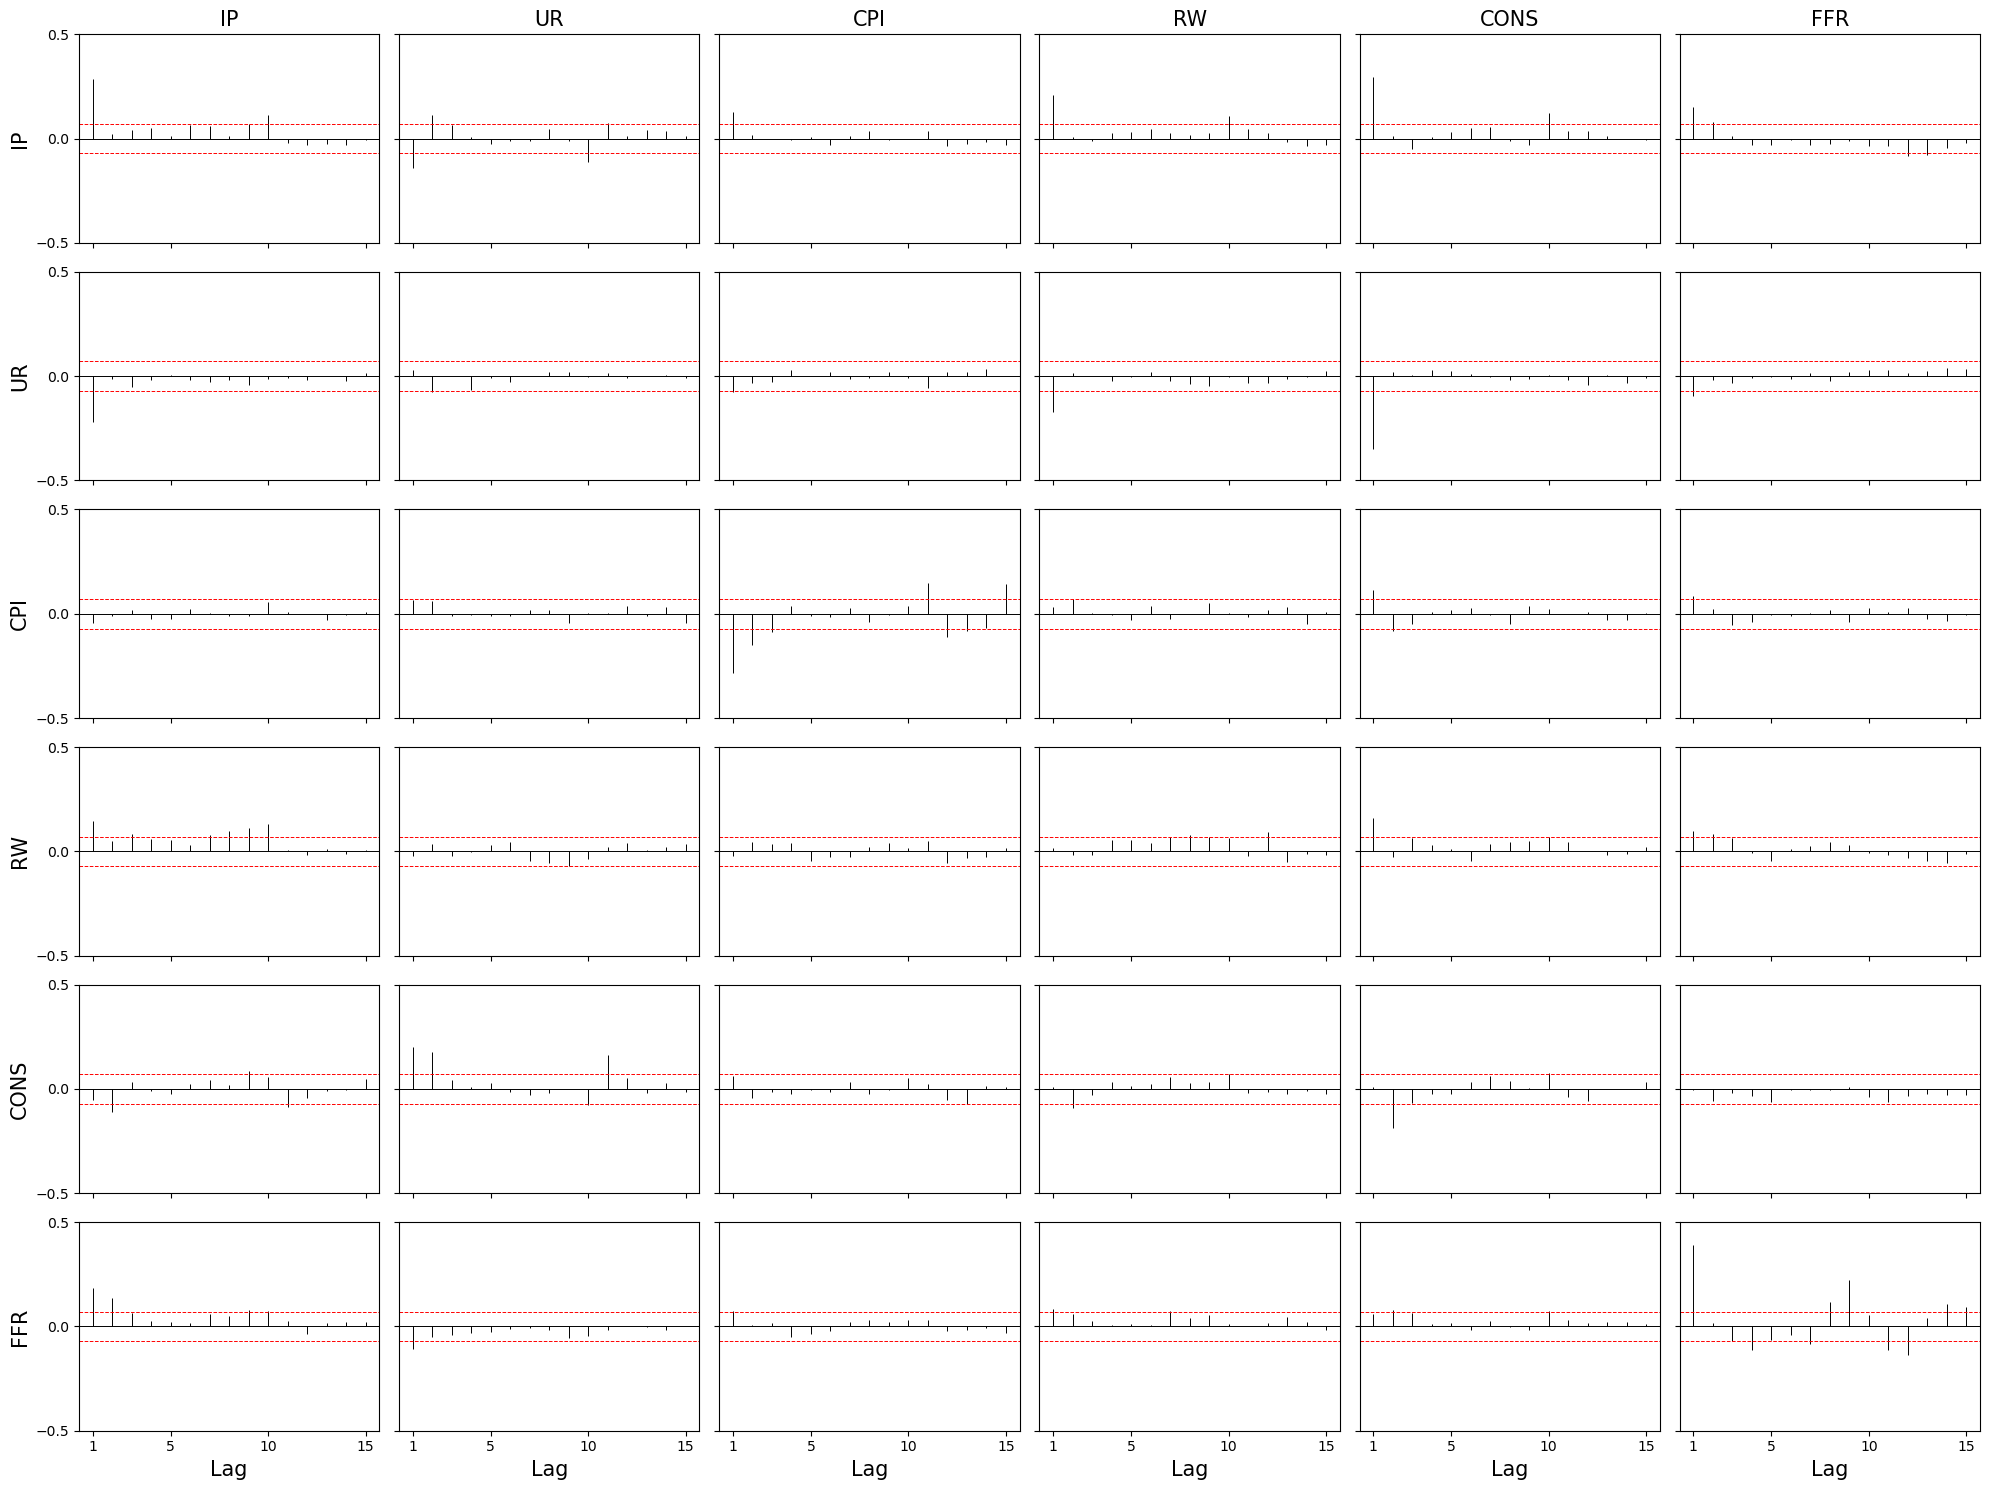

In [9]:
MACM_y = MACM(df_std.values, 15)   # K=15 lags: 1..15
K = MACM_y.shape[0]
T, N = df_std.shape

xlabel_lags = np.arange(1, K+1)

fig, axes = plt.subplots(N, N, figsize=(20, 15), sharex=True, sharey=True)

cols = list(df_std.columns) if hasattr(df_std, "columns") else [f"v{i}" for i in range(N)]

for i in range(N):
    for j in range(N):
        ax = axes[i, j]
        ax.vlines(xlabel_lags, 0, MACM_y[:, i, j], color='k', linewidth=0.7)
        ax.axhline(0, color='k', linewidth=0.7)

        # 使用近似界（常用写法）；若更严谨可用 2/sqrt(T-k) 做成曲线
        err_bound = 2 / np.sqrt(T)
        ax.axhline(err_bound, color='r', linestyle='--', linewidth=0.7)
        ax.axhline(-err_bound, color='r', linestyle='--', linewidth=0.7)

        # 行列标签：只在边缘放，节省空间
        if i == 0:
            ax.set_title(cols[j], fontsize=15)
        if j == 0:
            ax.set_ylabel(cols[i], fontsize=15)

        if i == N-1:
            ax.set_xticks([1, 5, 10, 15])
            ax.set_xlabel("Lag", fontsize=15)

        ax.set_yticks([-0.5, 0, 0.5])

plt.tight_layout()
plt.savefig("Application/MACM_realdata.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
y=df_std.values
T,N = df_std.shape

In [ ]:
est = SARMAEstimator()
est.fit(y,n_jobs_BIC=3)

In [15]:
est.fit(y,1,1,0)

In [16]:
est.summary()

'SARMA(p=1, r=1, s=0), loss=3.26013, P=200, n_iter=100, stop_thres=1e-06'

In [17]:
est._history['LS_result']['Sigma']

array([[ 0.81164548, -0.45497673,  0.06049437,  0.37590665,  0.46956726,
         0.13382202],
       [-0.45497673,  0.76539985, -0.05439446, -0.35062532, -0.51417533,
        -0.07635345],
       [ 0.06049437, -0.05439446,  0.68265873, -0.12390835,  0.02999307,
         0.03020159],
       [ 0.37590665, -0.35062532, -0.12390835,  0.89538416,  0.40753241,
         0.0602177 ],
       [ 0.46956726, -0.51417533,  0.02999307,  0.40753241,  0.8724318 ,
         0.08476719],
       [ 0.13382202, -0.07635345,  0.03020159,  0.0602177 ,  0.08476719,
         0.8054857 ]])

In [18]:
est.get_params()

{'loss': 3.260132339671566,
 'p': 1,
 'r': 1,
 's': 0,
 'lmbd': array([0.84208839]),
 'eta': array([], shape=(0, 2), dtype=float64),
 'G': array([[[ 0.17553179,  0.08758437],
         [ 0.25610452,  0.17850746],
         [ 0.15399132,  0.10110432],
         [ 0.09218252, -0.00596038],
         [ 0.25375674,  0.08429577],
         [ 0.09630554, -0.01764754]],
 
        [[-0.14824806, -0.06381737],
         [-0.45956365, -0.08841085],
         [-0.13279006, -0.14057105],
         [-0.06804478,  0.03590357],
         [-0.49250686, -0.06830834],
         [-0.04350019, -0.00977777]],
 
        [[-0.02608528,  0.010058  ],
         [ 0.10581619,  0.06424521],
         [-0.57728045, -0.7030543 ],
         [-0.08601384,  0.01986736],
         [ 0.24279585,  0.08079251],
         [ 0.12799895,  0.05410753]],
 
        [[ 0.13510372,  0.13578035],
         [ 0.24029451,  0.15887422],
         [-0.03386069,  0.02612377],
         [-0.12951308, -0.06161648],
         [ 0.26377438,  0.12102622],
  

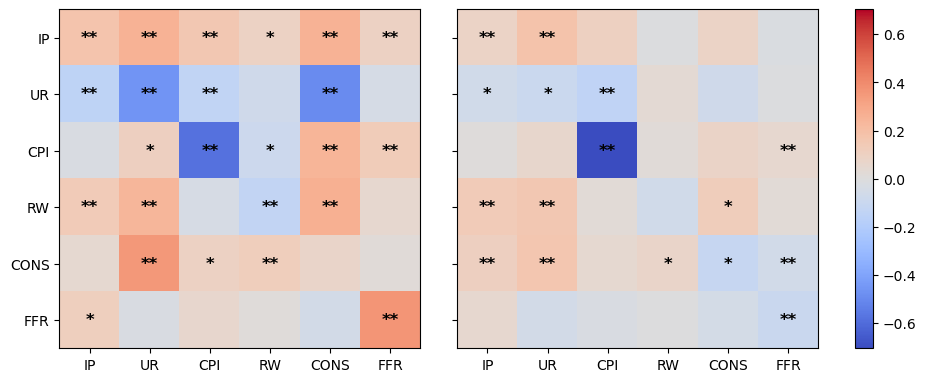

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.gridspec import GridSpec

# ----------------------------
# 1) Extract parameters
# ----------------------------
G0 = est.get_params()['G'][:, :, 0]
G1 = est.get_params()['G'][:, :, 1]

asyvar_diag = np.diag(est.get_params()['AsyVar'])
se_G0 = np.sqrt(asyvar_diag)[1 : 1 + N*N]
se_G1 = np.sqrt(asyvar_diag)[1 + N*N : 1 + 2*N*N]

SE0 = se_G0.reshape(N, N, order='F')
SE1 = se_G1.reshape(N, N, order='F')

# Robust z-stat to avoid division by tiny SE
eps = 1e-12
Z0 = G0 / np.maximum(SE0, eps)
Z1 = G1 / np.maximum(SE1, eps)

# ----------------------------
# 2) Significance thresholds (two-sided)
# ----------------------------
z_5 = norm.ppf(1 - 0.05 / 2)  # 1.959963...
z_1 = norm.ppf(1 - 0.01 / 2)  # 2.575829...

sig0_5 = np.abs(Z0) > z_5
sig0_1 = np.abs(Z0) > z_1
sig1_5 = np.abs(Z1) > z_5
sig1_1 = np.abs(Z1) > z_1

# ----------------------------
# 3) Common color scale (symmetric)
# ----------------------------
vmax = max(np.abs(G0).max(), np.abs(G1).max())
vmin = -vmax

# ----------------------------
# 4) Layout: 1 row, 2 panels + dedicated colorbar column
# ----------------------------
fig = plt.figure(figsize=(10.5, 4.4))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.15)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
cax = fig.add_subplot(gs[0, 2])

def draw_panel(ax, G, sig5, sig1):
    im = ax.imshow(G, cmap='coolwarm', vmin=vmin, vmax=vmax, aspect='auto')
    for i in range(N):
        for j in range(N):
            if sig1[i, j]:
                ax.text(j, i, '**', ha='center', va='center',
                        color='black', fontsize=12, fontweight='bold')
            elif sig5[i, j]:
                ax.text(j, i, '*', ha='center', va='center',
                        color='black', fontsize=12, fontweight='bold')
    # ax.set_title(title)
    ax.set_xticks(range(N))
    ax.set_yticks(range(N))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    # ax.set_xlabel('j')
    return im

im0 = draw_panel(ax0, G0, sig0_5, sig0_1)
im1 = draw_panel(ax1, G1, sig1_5, sig1_1)
# ax0.set_ylabel('i')
plt.setp(ax1.get_yticklabels(), visible=False)

# shared colorbar placed nicely
cbar = fig.colorbar(im1, cax=cax)
# cbar.set_label('Coefficient value')

# note inside the figure canvas (won't be cut)
# fig.text(
#     0.5, 0.01,
#     r'Notes: ** significant at 1%, * significant at 5% (two-sided, asymptotic standard errors).',
#     ha='center', fontsize=10
# )

plt.savefig('Application/coef_G.pdf')


In [20]:
G1.ravel('F')

array([ 0.08758437, -0.06381737,  0.010058  ,  0.13578035,  0.10634619,
        0.05485725,  0.17850746, -0.08841085,  0.06424521,  0.15887422,
        0.16379638, -0.05248763,  0.10110432, -0.14057105, -0.7030543 ,
        0.02612377,  0.0474281 , -0.02455413, -0.00596038,  0.03590357,
        0.01986736, -0.06161648,  0.07294441, -0.00450902,  0.08429577,
       -0.06830834,  0.08079251,  0.12102622, -0.11512534, -0.04675637,
       -0.01764754, -0.00977777,  0.05410753,  0.02523119, -0.05763665,
       -0.09362075])

In [21]:
se_G1

array([0.03029027, 0.02876968, 0.02648933, 0.03256136, 0.03113374,
       0.02916087, 0.04092265, 0.03790085, 0.03633982, 0.04212696,
       0.04234393, 0.03854139, 0.0537392 , 0.05221168, 0.05067108,
       0.05636685, 0.05576664, 0.05352038, 0.03147059, 0.03063179,
       0.02966331, 0.0330621 , 0.03292467, 0.0313924 , 0.04532615,
       0.04344454, 0.04127052, 0.04724094, 0.04618723, 0.04443919,
       0.0208585 , 0.02025619, 0.0190969 , 0.02196404, 0.02212214,
       0.02172156])

In [22]:
np.abs(G1.ravel('F')/se_G1)

array([ 2.89150208,  2.21821637,  0.37970012,  4.16998382,  3.41578572,
        1.88119375,  4.36207008,  2.33268797,  1.76790116,  3.77131985,
        3.86823729,  1.3618507 ,  1.88138856,  2.6923294 , 13.87486416,
        0.46345989,  0.85047441,  0.45878091,  0.18939527,  1.1721015 ,
        0.66976195,  1.86365866,  2.21549364,  0.14363415,  1.85976034,
        1.57231104,  1.9576323 ,  2.56189261,  2.49257931,  1.05214269,
        0.8460598 ,  0.48270543,  2.83331459,  1.14875031,  2.60538339,
        4.31003738])

In [23]:
df_std.shape

(798, 6)

In [24]:
# 检查：Z 的数值尺度是否合理（例如大量极端 |z|>50 说明错位）
print(np.nanmin(np.abs(Z0)), np.nanmedian(np.abs(Z0)), np.nanmax(np.abs(Z0)))
print(np.nanmin(np.abs(Z1)), np.nanmedian(np.abs(Z1)), np.nanmax(np.abs(Z1)))

0.3647908713508862 2.8011753781400612 16.02585921531301
0.1436341459656519 1.881291156987214 13.874864160772244


In [25]:
# forecast function for SARMA
def for_SARMA(y_train, y_test, h=1, method = 'rolling'):
    '''
    h: h-step forecast;
    method: rolling--fix window;
            recursive--fix start point
    -----------------------------------
    output:
    N*[length(y_test)-h+1]
    '''
    T_train,N = y_train.shape
    T_test = y_test.shape[0]
    y_oos_MLE = np.zeros((T_test-h+1,N)) ## save forecasts
    y_oos_LS = np.zeros((T_test-h+1,N))
    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.vstack((y_train[t:], y_test[:t])) 
        elif method  == "recursive":
            y = np.vstack((y_train, y_test[:t])) 
        est = SARMAEstimator()
        est.fit(y,1,1,0)
        y_oos_MLE[t] = est.predict(y)

        est._fitted.G = est._history['LS_result']['G']
        est._fitted.lmbd = est._history['LS_result']['lmbd']
        est._fitted.eta = est._history['LS_result']['eta']
        y_oos_LS[t] = est.predict(y)
        
        
    return y_oos_MLE, y_oos_LS

In [26]:
# forecast function for VAR_LS

def for_VAR(y_train, y_test ,h=1, method = 'rolling'):
    T_train,N = y_train.shape
    T_test = y_test.shape[0]
    y_oos = np.zeros((T_test-h+1,N)) ## save forecasts

    for t in range(T_test-h+1):
        if method == "rolling":
            y = np.vstack((y_train[t:], y_test[:t])) 
        elif method  == "recursive":
            y = np.vstack((y_train, y_test[:t])) 
        model = VAR(y)
        results = model.fit(2)
        y_oos[t]= results.forecast(y[-2:],steps=1)
    return y_oos



In [27]:
from OtherModel.IOLS_VARMA1 import *

In [28]:
from statsmodels.tsa.statespace.varmax import VARMAX

def build_varmax_start_params_from_AB(mod: VARMAX, A: np.ndarray, B: np.ndarray):
    sp = np.array(mod.start_params, dtype=float)
    names = mod.param_names
    cols = list(mod.endog_names)
    name_to_idx = {n: i for i, n in enumerate(names)}
    N = len(cols)

    for dep_i, dep in enumerate(cols):
        for reg_j, reg in enumerate(cols):
            k_ar = f"L1.{reg}.{dep}"
            if k_ar in name_to_idx:
                sp[name_to_idx[k_ar]] = A[dep_i, reg_j]
            k_ma = f"L1.e({reg}).{dep}"
            if k_ma in name_to_idx:
                sp[name_to_idx[k_ma]] = B[dep_i, reg_j]
    return sp

def varmax_fit_forecast_with_iols_start(
    y: np.ndarray,
    A: np.ndarray,
    B: np.ndarray,
    steps: int = 1,
    maxiter: int = 200,
):
    y = np.asarray(y, dtype=float)
    T, N = y.shape
    df = pd.DataFrame(y, columns=[f"y{i+1}" for i in range(N)])

    mod = VARMAX(df, order=(1, 1), trend="n")
    sp = build_varmax_start_params_from_AB(mod, A, B)

    res = mod.fit(start_params=sp, method="lbfgs", maxiter=maxiter, disp=False)
    fc = np.asarray(res.forecast(steps=steps))  # (steps, N)
    return fc[-1, :]

In [29]:
from joblib import Parallel, delayed
from threadpoolctl import threadpool_limits

def for_VARMA(
    y_train: np.ndarray,
    y_test: np.ndarray,
    h: int = 1,
    method: str = "rolling",
    n_jobs: int = 50,
    burn_in: int = 5,
    ridge: float = 1e-8,
    maxiter_mle: int = 200,
):
    """
    Compare VARMA(1,1) one-step (or h-step) forecasts:
      - IOLS plug-in
      - VARMAX MLE initialized by IOLS

    y_train: (T_train, N)
    y_test : (T_test, N)
    method : 'rolling' or 'recursive'
    h      : forecast horizon (>=1). We store the h-step ahead forecast.

    Returns
    -------
    y_oos_IOLS: (T_test-h+1, N)
    y_oos_MLE : (T_test-h+1, N)
    """
    y_train = np.asarray(y_train, dtype=float)
    y_test = np.asarray(y_test, dtype=float)

    T_train, N = y_train.shape
    T_test = y_test.shape[0]
    if h < 1:
        raise ValueError("h must be >= 1")
    L = T_test - h + 1
    if L <= 0:
        raise ValueError("T_test must be >= h")

    def _one_task(t: int):
        # Avoid nested threading inside each process (MKL/OpenBLAS/BLIS)
        with threadpool_limits(limits=1):
            if method == "rolling":
                # keep fixed length = T_train
                # for large t, this assumes you want a rolling window of length T_train
                if t > T_train:
                    # If test longer than train, rolling window needs to slide into test as well.
                    # Window is the last T_train obs from the concatenated series.
                    y_all = np.vstack((y_train, y_test[:t]))
                    y = y_all[-T_train:, :]
                else:
                    y = np.vstack((y_train[t:], y_test[:t]))
            elif method == "recursive":
                y = np.vstack((y_train, y_test[:t]))
            else:
                raise ValueError("method must be 'rolling' or 'recursive'")

            # 1) IOLS fit
            A_iols, B_iols, u_iols, _ = varma11_iols_fit_no_c(
                y, burn_in=burn_in, ridge=ridge
            )

            # IOLS h-step forecast: iterate h times using plug-in residuals as 0 beyond last observed
            # Practical convention: after 1-step, future innovations set to 0 so MA term uses last available u only once.
            # Here we do: y_{T+1}=A y_T + B u_T, and for k>=2: y_{T+k}=A y_{T+k-1}
            y_hat = varma11_iols_forecast1(y, A_iols, B_iols, u_iols)
            if h > 1:
                for _ in range(h - 1):
                    y_hat = A_iols @ y_hat
            y_iols = y_hat

            # 2) VARMAX(MLE) with IOLS start; take h-step ahead (last step)
            # varmax_fit_forecast1_with_iols_start currently returns 1-step.
            # We'll call VARMAX once and forecast h steps.
            # (Implement by slightly extending your helper to accept steps.)
            y_mle = varmax_fit_forecast_with_iols_start(y, A_iols, B_iols, steps=h, maxiter=maxiter_mle)

            return t, y_iols, y_mle

    # Run in parallel
    out = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
        delayed(_one_task)(t) for t in range(L)
    )

    # Collect
    y_oos_IOLS = np.zeros((L, N))
    y_oos_MLE = np.zeros((L, N))
    for t, yi, ym in out:
        y_oos_IOLS[t, :] = yi
        y_oos_MLE[t, :] = ym

    return y_oos_IOLS, y_oos_MLE

In [34]:
# forecasting setting
y_train =y[:-60]
y_test=y[-60:]
h=1 

# forecasst
forecast_SARMA_LS,forecast_SARMA_MLE = for_SARMA(y_train, y_test, h=1, method = 'rolling')

In [35]:
forcast_VARMA_IOLS,forcast_VARMA_MLE = for_VARMA(y_train, y_test ,h=1, method = 'rolling')


/home/yxcai/anaconda3/envs/videop2p/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/yxcai/anaconda3/envs/videop2p/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/yxcai/anaconda3/envs/videop2p/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/yxcai/anaconda3/envs/videop2p/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationW

In [36]:
forecast_VAR_LS = for_VAR(y_train, y_test, h=1 ,method = 'rolling')

In [37]:
def mse(y_true, y_pred):
    return np.mean(((y_true - y_pred) ** 2).ravel('F'))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred).ravel('F'))

In [38]:
h = -60

forecasts = {
    "SARMA_LS":  forecast_SARMA_LS,
    "SARMA_MLE": forecast_SARMA_MLE,
    "VAR_LS":    forecast_VAR_LS,
    "VARMA_IOLS": forcast_VARMA_IOLS,
    "VARMA_MLE":  forcast_VARMA_MLE,
}
results = {}

for name, y_pred in forecasts.items():
    # assert y_pred.shape == y_test.shape, f"{name} shape mismatch"
    results[name] = {
        "MSE": mse(y_test[h:], y_pred[h:]),
        "MAE": mae(y_test[h:], y_pred[h:]),
    }

# 打印
for name, r in results.items():
    print(f"{name:12s} | MSE = {r['MSE']:.6f} | MAE = {r['MAE']:.6f}")

SARMA_LS     | MSE = 0.722273 | MAE = 0.546018
SARMA_MLE    | MSE = 0.717783 | MAE = 0.544301
VAR_LS       | MSE = 0.774155 | MAE = 0.562168
VARMA_IOLS   | MSE = 0.827550 | MAE = 0.578242
VARMA_MLE    | MSE = 0.728461 | MAE = 0.554886


In [110]:
def mse_t(y_true, y_pred):
    # y_true, y_pred: (T, N)
    return np.mean((y_true - y_pred) ** 2, axis=1)  # (T,)

def mae_t(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=1)

errors = {}

for name, y_pred in forecasts.items():
    y_pred_60 = y_pred[h:]
    errors[name] = {
        "MSE_t": mse_t(y_test[h:], y_pred_60),  # shape (60,)
        "MAE_t": mae_t(y_test[h:], y_pred_60),
    }
model_names = list(forecasts.keys())
T60 = 60

winner_mse = []

for t in range(-h):
    mse_at_t = {name: errors[name]["MSE_t"][t] for name in model_names}
    winner = min(mse_at_t, key=mse_at_t.get)
    winner_mse.append(winner)

model_names = list(forecasts.keys())
T60 = 60

winner_mse = []

for t in range(-h):
    mse_at_t = {name: errors[name]["MSE_t"][t] for name in model_names}
    winner = min(mse_at_t, key=mse_at_t.get)
    winner_mse.append(winner)

from collections import Counter

win_count_mse = Counter(winner_mse)

for name in model_names:
    print(f"{name:12s} wins (MSE): {win_count_mse.get(name, 0)} / 60")


SARMA_LS     wins (MSE): 4 / 60
SARMA_MLE    wins (MSE): 4 / 60
VAR_LS       wins (MSE): 5 / 60
VARMA_IOLS   wins (MSE): 7 / 60
VARMA_MLE    wins (MSE): 4 / 60


In [61]:
SFE_table = pd.DataFrame(columns = ['SARMA_LS', 'SARMA_QML','VAR_LS', 'VARMA_IOLS','VARMA_QML'])
SAE_table = pd.DataFrame(columns = ['SARMA_LS', 'SARMA_QML','VAR_LS', 'VARMA_IOLS','VARMA_QML'])

SFE_table['SARMA_LS']= np.sqrt(np.mean((forecast_SARMA_LS - y_test) ** 2))
SFE_table['SARMA_QML']= np.sqrt(np.mean((forecast_SARMA_MLE - y_test) ** 2)) 
SFE_table['VAR_LS'] = np.sqrt(np.mean((forecast_VAR_LS - y_test) ** 2))  
SFE_table['VARMA_IOLS'] = np.sqrt(np.mean((forcast_VARMA_IOLS - y_test) ** 2)) 
SFE_table['VARMA_QML'] = np.sqrt(np.mean((forcast_VARMA_MLE - y_test) ** 2)) 


SAE_table['SARMA_LS']= np.linalg.norm(forecast_SARMA_LS-y_test,ord= 1,axis=1)
SAE_table['SARMA_QML']= np.linalg.norm(forecast_SARMA_MLE-y_test,ord= 1,axis=1)
SAE_table['VAR_LS'] = np.linalg.norm(forecast_VAR_LS-y_test,ord= 1,axis=1)
SAE_table['VARMA_IOLS'] = np.linalg.norm(forcast_VARMA_IOLS- y_test,ord=1,axis=1)
SAE_table['VARMA_QML'] = np.linalg.norm(forcast_VARMA_MLE-y_test,ord= 1,axis=1)

# rooted mean squared forecast error
RMSFE = np.sqrt(SFE_table.mean()).round(2)
print(f'RMSFE:\n{RMSFE}')
# mean absoluted forecast error
MAFE = SAE_table.mean().round(2)
print(f'MAFE:\n{MAFE}')

RMSFE:
SARMA_LS     NaN
SARMA_QML    NaN
VAR_LS       NaN
VARMA_IOLS   NaN
VARMA_QML    NaN
dtype: float64
MAFE:
SARMA_LS      3.72
SARMA_QML     3.73
VAR_LS        3.80
VARMA_IOLS    3.83
VARMA_QML     3.78
dtype: float64


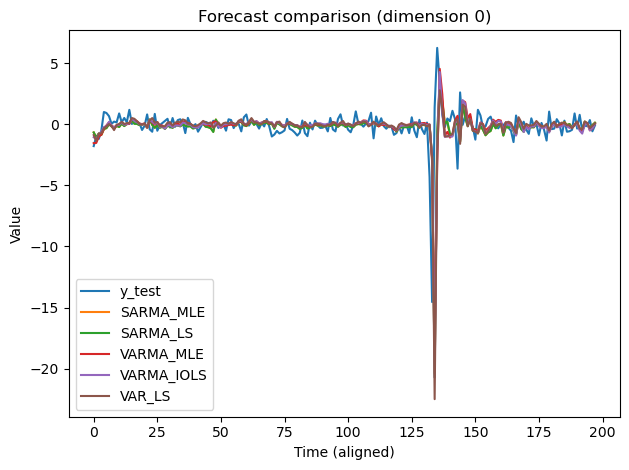

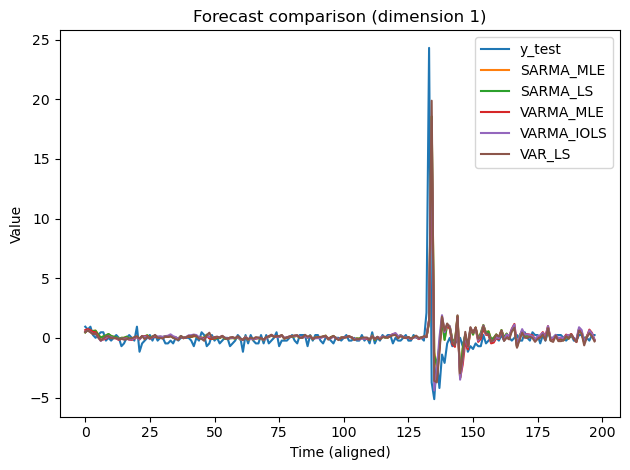

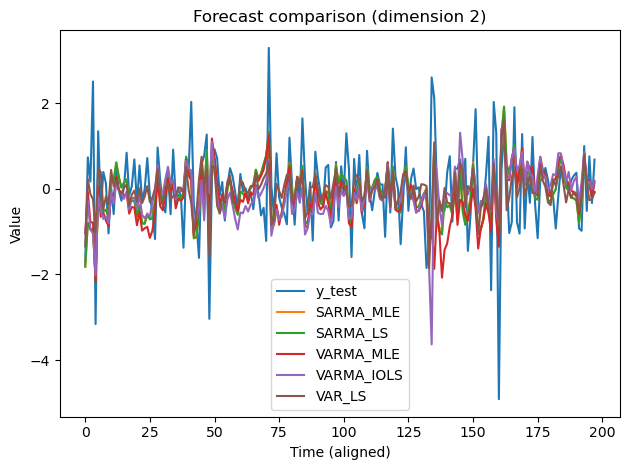

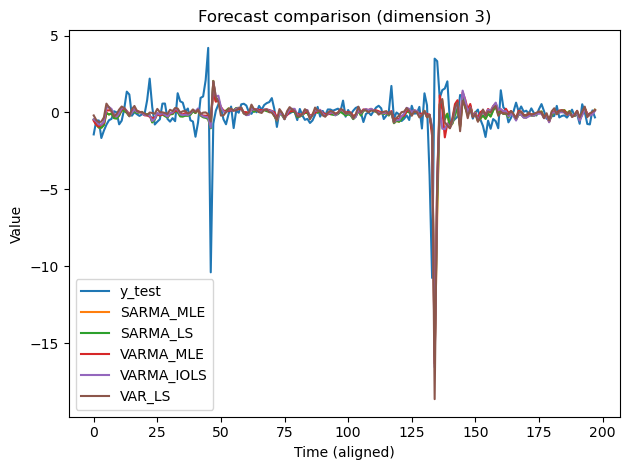

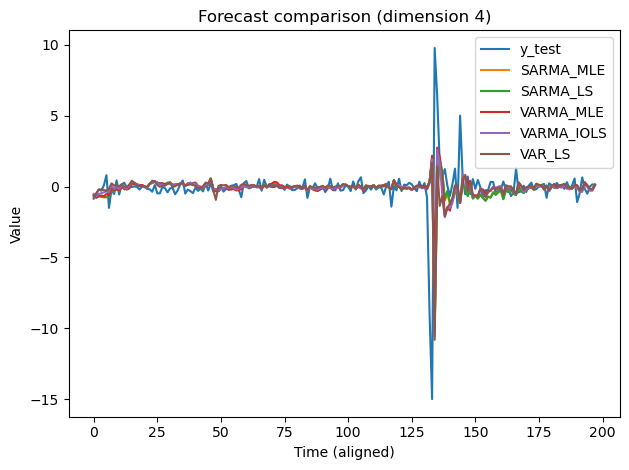

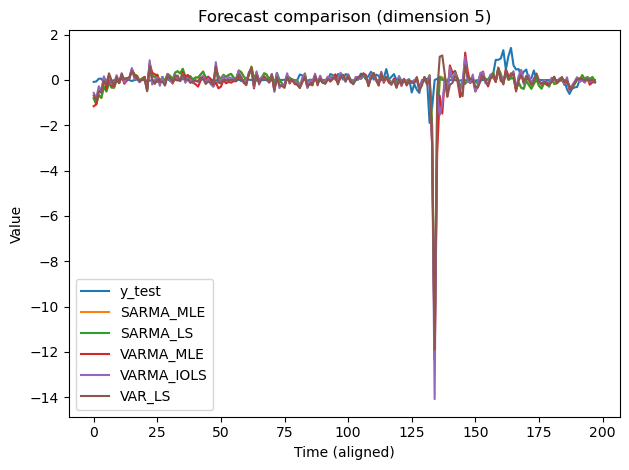

In [113]:
import matplotlib.pyplot as plt

# 你可以控制画多少个点
LAST_K = 200   # 例如 60 / 100 / 200；画全部就设为 None

def _slice_last(x, k):
    if k is None:
        return x
    return x[-k:]

# --------- 收集所有序列 ---------
series = {
    "y_test": y_test,
    "SARMA_MLE": forecast_SARMA_MLE,
    "SARMA_LS": forecast_SARMA_LS,
    "VARMA_MLE": forcast_VARMA_MLE,
    "VARMA_IOLS": forcast_VARMA_IOLS,
    "VAR_LS": forecast_VAR_LS,
}

# --------- 对齐长度（取最短）---------
L = min(v.shape[0] for v in series.values())
for k in series:
    series[k] = series[k][-L:]

# --------- 再取最后 LAST_K 个点 ---------
for k in series:
    series[k] = _slice_last(series[k], LAST_K)

T, N = series["y_test"].shape
assert N >= 6, f"Need at least 6 dimensions, got N={N}"

x = np.arange(T)

# --------- 逐维画图 ---------
for i in range(6):
    plt.figure()
    for name, y in series.items():
        plt.plot(x, y[:, i], label=name)
    plt.title(f"Forecast comparison (dimension {i})")
    plt.xlabel("Time (aligned)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()